# Brincadeirinha

In [1]:
import pickle
import datetime

import numpy as np
import pandas as pd


from matplotlib             import pyplot as plt
from matplotlib.gridspec    import GridSpec
from prophet                import Prophet

from IPython.display        import Image
from IPython.core.display   import HTML

from sklearn.preprocessing  import (StandardScaler, RobustScaler)

In [87]:
with open('../data/interim/3_0_feature_engineering.pkl', 'rb') as arquivo:
    df = pickle.load(arquivo)
df.sample()

,subscription_guid,date,resource_guid,service_name,service_type,service_region,service_resource,quantity,cost,maquina,...,semana_ano,ano_semana,ano_mes,dia_da_semana,fim_de_semana,custo_fixo_diario,custo_fixo_semanal,custo_fixo_mensal,custo_soma_movel_semanal,custo_soma_movel_mensal
53552,15dc64f3_696a_48fc_9169_8467e3f7bba0,2024-01-03,2dba9884_2518_4427_90ff_d2c100c5f775,Storage,Standard SSD Managed Disks,BR South,E6 LRS Disk,0.032256,0.289008,unicin,...,1,2024-01,2024-01,2,0,5.388883,37.222311,172.107617,37.194327,167.359717


CEAEC - 07 Jan 2025 - Mais ou menos - Aqui.

Editares - 08 Sep 2025 - Mais variado, talvez tenha que aumentar disco - Depois.

UNICIN - 12 Mar 2025 - Menos mexido - Aqui.

ICNET - ????

Normalmente, os créditos são disponibilizados 30 dias antes.

In [88]:
df['service_name'].unique()

array(['Storage', 'Azure DNS', 'Bandwidth', 'Virtual Network',
       'Log Analytics', 'Virtual Machines', 'Virtual Machines Licenses',
       'Automation', 'Azure Monitor', 'Network Watcher', 'SQL Database',
       'Azure App Service', 'Backup', 'Key Vault', 'Functions',
       'Logic Apps'], dtype=object)

### Filtro Máquina

In [89]:
df_maquina = df[
        (df['maquina'] == 'icnet') 
        ]

In [90]:
df_maquina['date'].max()

Timestamp('2024-11-11 00:00:00')

In [91]:
df_maquina['date'].min()

Timestamp('2024-03-09 00:00:00')

### Isolamento das variáveis

In [109]:
df_plot = df_maquina.loc[
            (df_maquina['date']>= '2024-10-06') &
            (df_maquina['date']<= '2024-11-06')
            ,
                [
                'date',
                'cost'
                ]
            ].groupby('date').sum().reset_index()

# plt.scatter(
#     df_plot['date'],
#     df_plot['cost'])
# df_plot.shape[0]
# df_plot

In [110]:
df_plot['cost'].sum()

773.930621

In [79]:
#filtro_data = (df["Date"])
#filtro_service_name = df['ServiceName'] == "Functions"
#filtro_service_resource = df['ServiceResource'] == "Premium vCPU Duration"

df_prep = df_maquina.loc[:, ["date", "cost"]].groupby("date").sum().reset_index()

In [80]:
df_prep.rename(columns = {"date":"ds", "cost":"y"}, inplace = True)

In [81]:
df_prep = df_prep.loc[df_prep['ds'] >= '2024-01-01',:]

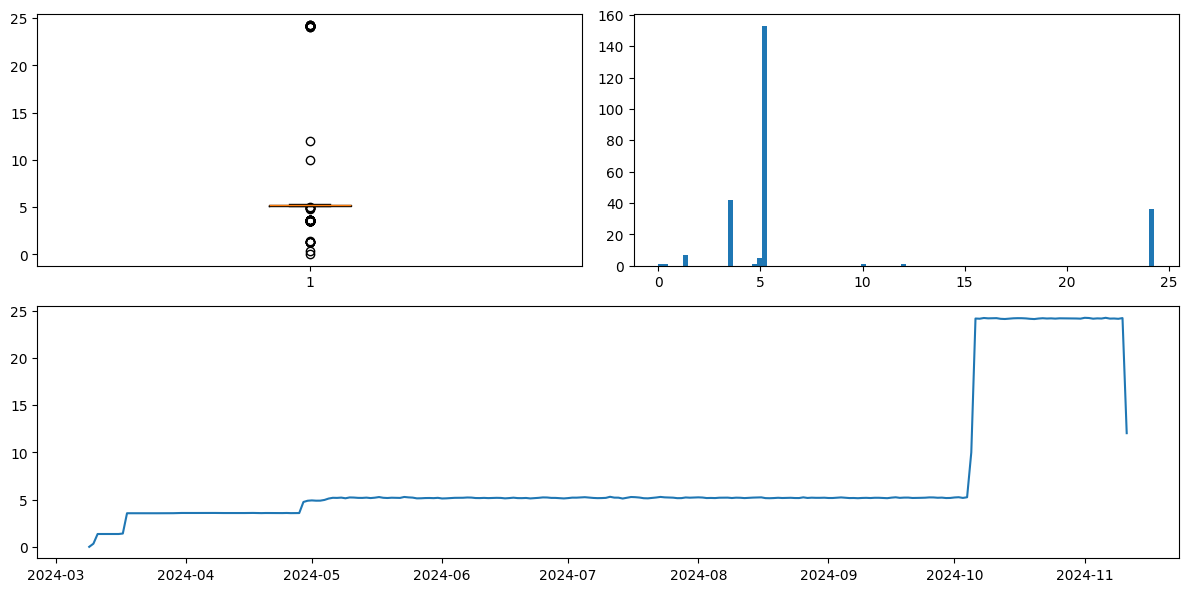

In [82]:
fig, axes = plt.subplots(2,2, figsize=(12,6))

fig.delaxes(axes[1, 1])
fig.delaxes(axes[1, 0])

axes[0,0].boxplot(df_prep['y']);

axes[0,1].hist(df_prep['y'],bins=100)

ax3 = fig.add_subplot(2,1,2)
ax3.plot(df_prep['ds'], df_prep['y'])

plt.tight_layout()
plt.show()

### Normalização dos dados e Reescala Z-score

In [83]:
df_model = df_prep.copy()

In [84]:
df_model['y'] = np.log1p(df_model['y'])

In [85]:
scaller = StandardScaler()
df_model['y'] = scaller.fit_transform(df_model[['y']])

#robst = RobustScaler()
#df_model['y'] = robst.fit_transform(df_model[['y']])

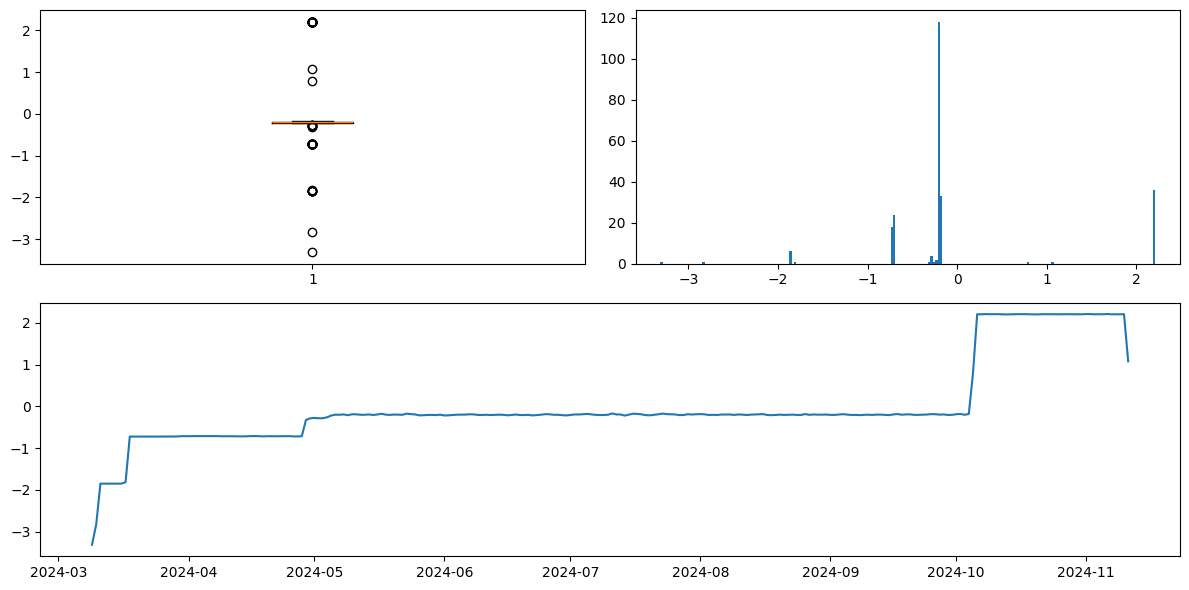

In [86]:
# plt.figure(figsize=(12, 5))
# plt.subplot(1,2,1)
# plt.boxplot(df_model['y']);

# plt.subplot(1,2,2)
# plt.plot(df_model['ds'], df_model['y'])

fig_model, axes_model = plt.subplots(2,2, figsize=(12,6))

fig_model.delaxes(axes_model[1, 1])
fig_model.delaxes(axes_model[1, 0])

axes_model[0,0].boxplot(df_model['y']);

axes_model[0,1].hist(df_model['y'],bins=200)

ax3 = fig_model.add_subplot(2,1,2)
ax3.plot(df_model['ds'], df_model['y'])

plt.tight_layout()
plt.show()

### Separação Treino x Teste

In [50]:
df_train = df_model.loc[df_model['ds'] <= '2024-09-30',:]
df_test = df_model.loc[df_model['ds'] > '2024-09-30',:]

In [52]:
#df_train.tail(5)

In [53]:
m = Prophet()
m.fit(df_train)
future = m.make_future_dataframe(periods=30)
future.info()

14:48:45 - cmdstanpy - INFO - Chain [1] start processing
14:48:45 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      304 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.5 KB


In [54]:
forecast = m.predict(future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [55]:
ds_future = forecast

In [63]:
futuro = ds_future.loc[ds_future["ds"] > "2024-09-30", [
                                                        'ds',
                                                        'yhat',
                                                        'yhat_lower',
                                                        'yhat_upper'
                                                        ]
                        ].groupby("ds").sum().reset_index()

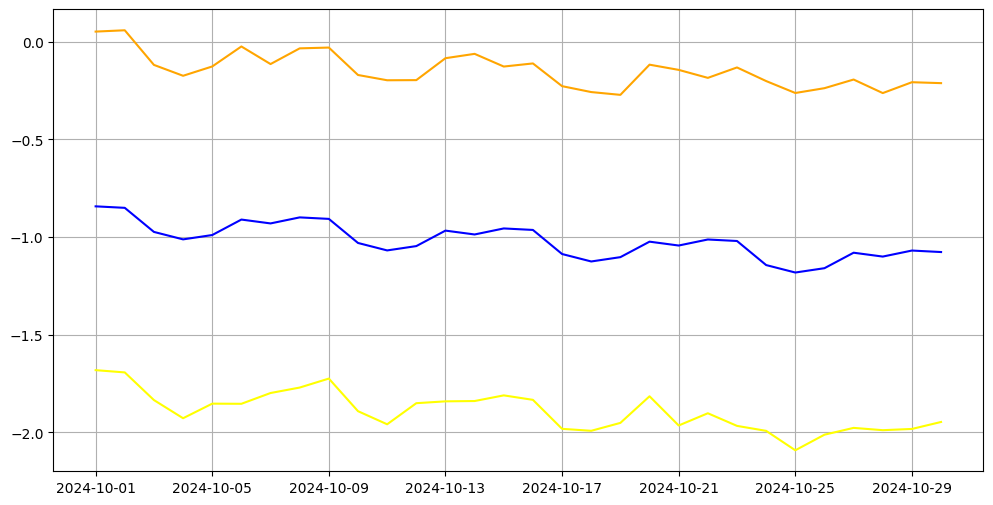

In [64]:
plt.figure(figsize=(12, 6))

plt.plot(futuro['ds'], futuro['yhat'], label='yhat', color='blue')
plt.plot(futuro['ds'], futuro['yhat_lower'], label='yhat_lower', color='yellow')
plt.plot(futuro['ds'], futuro['yhat_upper'], label='yhat_upper', color='orange')

plt.grid(True)
plt.show()

In [75]:
valor_futuro = futuro.loc[futuro['ds'] < '2024-10-30',['yhat']].sum()
#valor_futuro

In [71]:
valor_teste = df_test['y'].sum()
valor_teste

-16.77045577373354

In [72]:
((valor_futuro / valor_teste)-1)*100

yhat   -100.0
dtype: float64

In [68]:
#fig2 = m.plot_components(forecast)

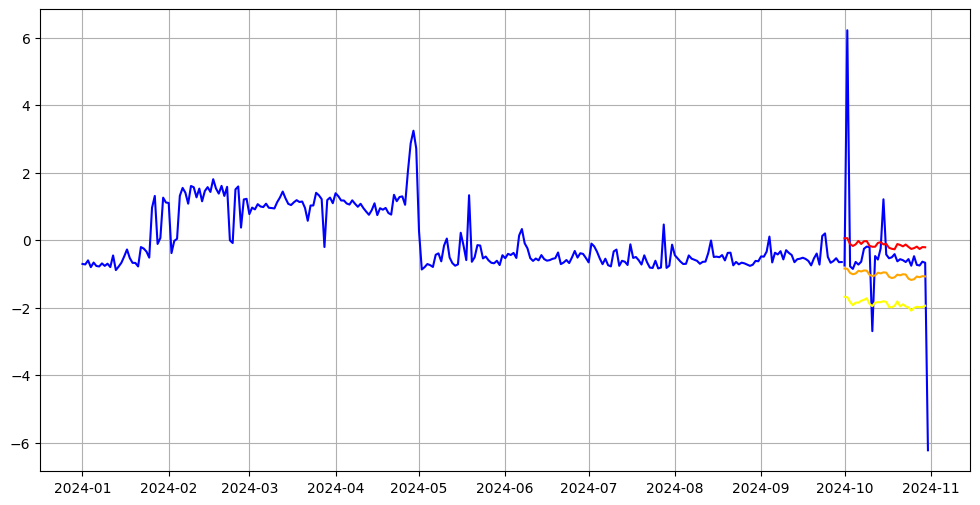

In [69]:
plt.figure(figsize=(12, 6))

plt.plot(df_test['ds'], df_test['y'], label='Dataset 1', color='blue')
plt.plot(df_train['ds'], df_train['y'], label='Dataset 1', color='blue')

plt.plot(futuro['ds'], futuro['yhat'], label='yhat', color='orange')
plt.plot(futuro['ds'], futuro['yhat_lower'], label='yhat_lower', color='yellow')
plt.plot(futuro['ds'], futuro['yhat_upper'], label='yhat_upper', color='red')

plt.grid(True)
plt.show()

In [76]:
futuro[['yhat_upper','yhat','yhat_lower']].sum()

yhat_upper    80.512897
yhat          61.589627
yhat_lower    42.809076
dtype: float64

In [ ]:
print(df_test['ds'].min())
print(df_test['ds'].max())

2024-10-01 00:00:00
2024-11-11 00:00:00


In [ ]:
futuro.loc[futuro['ds']<='2024-12-31',['yhat_upper','yhat','yhat_lower']].sum()

yhat_upper    532.496822
yhat          480.398868
yhat_lower    429.425258
dtype: float64

In [ ]:
valor_teste

913.6184810000001

In [ ]:
futuro.loc[futuro['ds']<'2025-06-01',['yhat_upper','yhat','yhat_lower']].sum()

yhat_upper    1568.809774
yhat          1270.386286
yhat_lower     981.405969
dtype: float64